In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import minimum_spanning_tree
import networkx as nx
from numpy import linalg as LA
from datetime import datetime
import random
import time
import datetime

In [4]:
def get_len_H(dat):
    ans = len(dat[0]['<CLOSE>'])
    for i in range(1, len(dat)):
        ans = min(len(dat[i]['<CLOSE>']), ans)
    if ans == 0:
        for i in range(0, len(dat)):
            print(len(dat[i]['<CLOSE>']))
    return ans

def get_H_matrix(dat, len_):
    H_matrix = []
    for i in range(len(dat)):
        H_i = dat[i]['<CLOSE>'].to_numpy()
        H_i = H_i[:len_]
        if H_i.std() != 0:
            H_matrix.append(H_i)
    return H_matrix

def get_metrix(correl_matrix):
    return np.sqrt(2 * (1 - correl_matrix))

def get_eigen_values(assets, start_date):
    #min len
    len_of_matrix = get_len_H(assets)
    #make matrix from df
    matrix = get_H_matrix(assets, len_of_matrix)
    #calculate correlations
    correlation = np.corrcoef(matrix)
    #calculate eigenvalues
    v, w = LA.eig(correlation)
    return (np.max(v).real, start_date)

def get_minimum_spanning_tree(assets):
    #min len
    len_of_matrix = get_len_H(assets)
    #make matrix from df
    matrix = get_H_matrix(assets, len_of_matrix)
    #calculate correlations
    correlation = np.corrcoef(matrix)
    #calculate distance
    metric = get_metrix(correlation)
    #find minimum spanning tree
    Tree = minimum_spanning_tree(metric)
    Tree = Tree.toarray().astype(float)
    return Tree
    
    


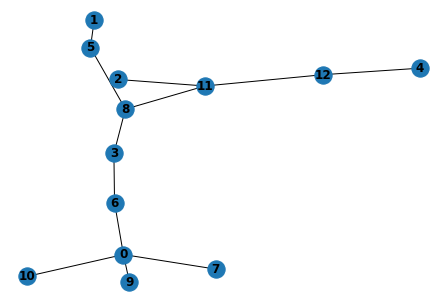

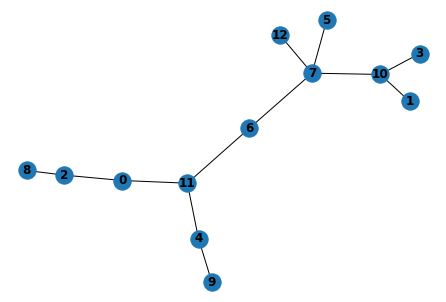

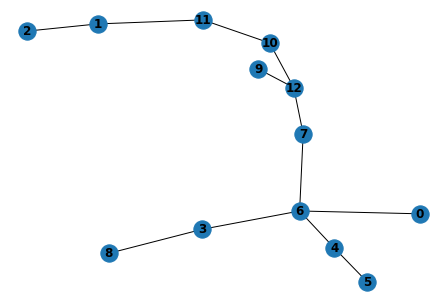

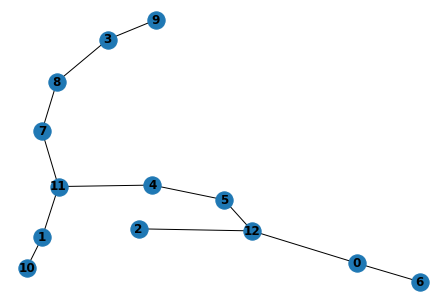

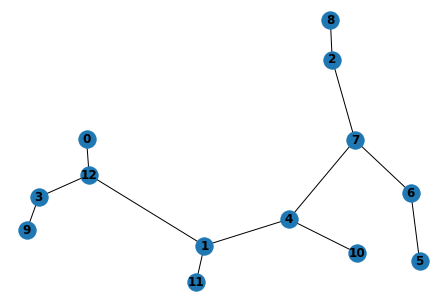

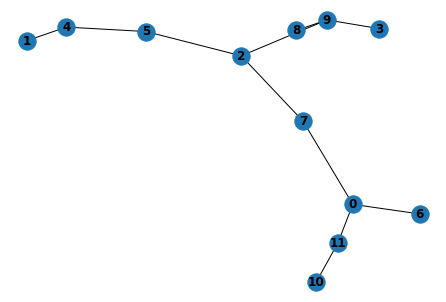

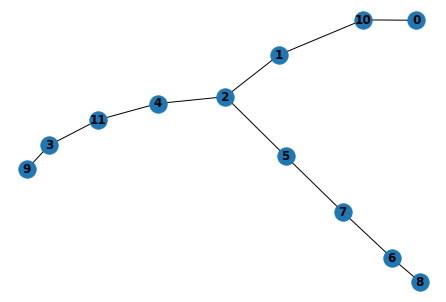

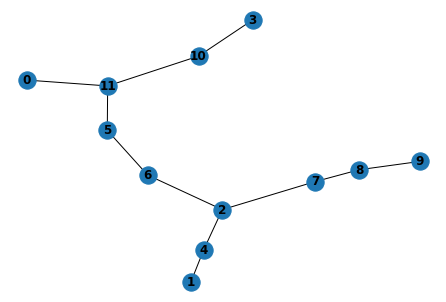

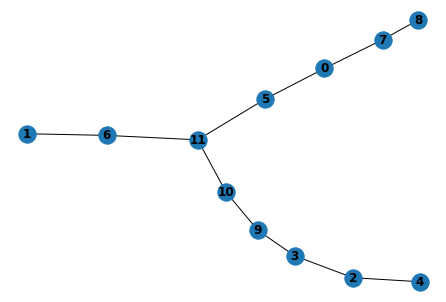

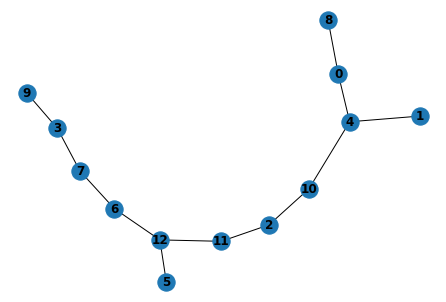

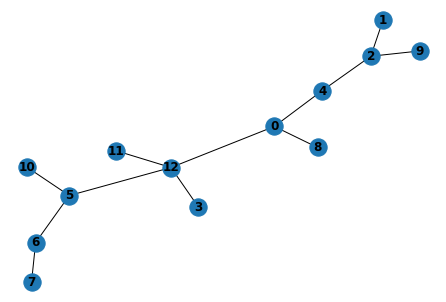

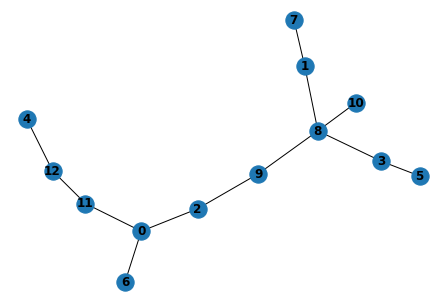

In [17]:
s = '2020-01-10'
e = '2020-07-01'
number_of_days = 14
quant = 86400 * number_of_days

start_int = time.mktime(datetime.datetime.strptime(s, "%Y-%m-%d").timetuple())
end_int = time.mktime(datetime.datetime.strptime(e, "%Y-%m-%d").timetuple())
num_steps = int((end_int - start_int) / quant)

v, w = [0 for _ in range(num_steps)], [0 for _ in range(num_steps)]
v_best, w_best = [0 for _ in range(num_steps)], [0 for _ in range(num_steps)]
eigen_data = [0 for _ in range(num_steps)]
eigen_data_best = [0 for _ in range(num_steps)]
eigen_data_random = [0 for _ in range(num_steps)]
tickers = ['GAZP', 'LSNGP', 'ALRS', 'ROSN', 'RSTIP', 'BANEP', 'SIBN', 'TATNP',
           'LKOH', 'SNGSP', 'NKNCP', 'SBERP', 'VTBR']

DATAFRAME = []
for ticker in tickers:
    data = pd.read_csv(ticker + ".csv", header=0, sep=';')
    s = data['<DATE>']
    data['<DATE>'] = pd.to_datetime(s, infer_datetime_format=True, dayfirst=True) 
    if not data.empty:
        DATAFRAME.append(data)
interesting = [2, 6, 9, 10]    
eigen_data_inter = [0 for _ in range(num_steps)]
for i in range(num_steps):

    start_date = datetime.datetime.utcfromtimestamp(start_int + 86400).strftime('%Y-%m-%d')
    end_date = datetime.datetime.utcfromtimestamp(start_int + quant + 86400).strftime('%Y-%m-%d')
               
    df = []  
    df_empty = 0
    
    
    for data in DATAFRAME:
        data = data[(data['<DATE>'] < end_date) & (data['<DATE>'] > start_date)]
        if not data.empty:
            df.append(data)
            df_empty += 1
    
    if df_empty < 2:
        start_int += quant
        continue
    
    eigen_data[i] = get_eigen_values(df, start_date) 

    Tree = get_minimum_spanning_tree(df)
    G = nx.from_numpy_matrix(Tree, parallel_edges=False)

    #choose the best assets
    best_assets = []
    for node in G.nodes():
        if G.degree[node] == 1:
            best_assets.append(df[node])
    
    random_assets = []
    num_to_select = len(best_assets)                           
    list_of_random_items = random.sample(G.nodes(), num_to_select)
    for random_asset_name in list_of_random_items:
        random_assets.append(df[random_asset_name])
    
    interesting_assets = []
    for int_asset_name in interesting:
        interesting_assets.append(df[int_asset_name])
    
    eigen_data_inter[i] = get_eigen_values(interesting_assets, start_date) 
    eigen_data_random[i] = get_eigen_values(random_assets, start_date) 
    eigen_data_best[i] = get_eigen_values(best_assets, start_date) 

    nx.draw(G, with_labels=True, font_weight='bold')  # networkx draw()
    plt.show()
    
    start_int += quant

3.146311018576513 2.628594609964312


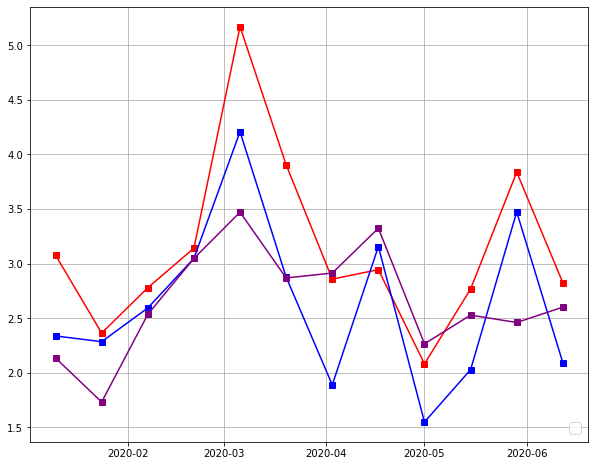

In [18]:
y = [0 for _ in range(num_steps)]
z = [0 for _ in range(num_steps)]
x = [i for i in range(num_steps)]
p = [0 for _ in range(num_steps)]


# datetime_str = f'{start_year + year}-{month}-01'
# datetime_object = datetime.strptime(datetime_str, '%m/%d/%y %H:%M:%S')
for i in range(num_steps):
    z[i] = eigen_data_best[i][0]
    y[i] = eigen_data_random[i][0]
    p[i] = eigen_data_inter[i][0]
    x[i] = datetime.datetime.strptime(eigen_data[i][1], '%Y-%m-%d')
fig = plt.figure(figsize=(10,8))
legend = []
# plt.xlabel('$Days \ before \ dividend$', fontsize=15)
# plt.ylabel("$Yield \ for \ the \ day \ before \ the \ dividend \ cutoff, $" + '%', fontsize=15)
print(np.array(y).mean(), np.array(z).mean())
# err = frame['diviation of mean, %']
plt.plot(x, y, marker='s', color = 'r')
plt.plot(x, z, marker='s', color = 'b')
plt.plot(x, p, marker='s', color = 'purple')
# legend.append(f'GAZP, {len(proc)} dividends statistics')
plt.legend(legend, loc="lower right", fontsize=15)
plt.grid()


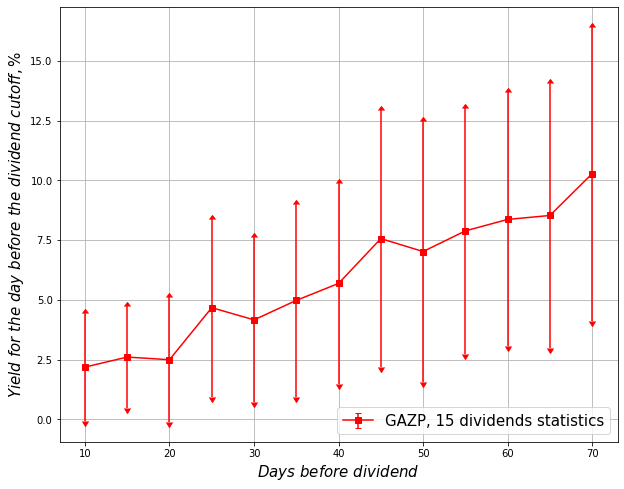

In [222]:
data = pd.read_csv("GAZP.csv", header=0, sep=';')
div_data = pd.read_csv('gazp_div.csv', header=0, sep=';')

s = div_data['data']
div_data['data'] = pd.to_datetime(s, infer_datetime_format=True, dayfirst=True) 

s = data['<DATE>']
data['<DATE>'] = pd.to_datetime(s, infer_datetime_format=True, dayfirst=True) 
proc_days = []
for days in range(10, 75, 5):
    proc = []
    for x in div_data['data']:
        idx_div = data[data['<DATE>'] == x].index - 2
        idx_two_months = idx_div - days
        if not data.loc[idx_div, '<CLOSE>'].empty:
            proc.append((float(data.loc[idx_div, '<CLOSE>']) - float(data.loc[idx_two_months, '<CLOSE>'])) / float(data.loc[idx_two_months, '<CLOSE>']) * 100)
    proc = np.array(proc)
#     print(proc, days)
    proc_days.append({'mean, %': proc.mean(), 'diviation of mean, %': proc.std() / np.sqrt(len(proc)), 'days': days})
frame = pd.DataFrame(proc_days)


fig = plt.figure(figsize=(10,8))
legend = []
plt.xlabel('$Days \ before \ dividend$', fontsize=15)
plt.ylabel("$Yield \ for \ the \ day \ before \ the \ dividend \ cutoff, $" + '%', fontsize=15)
x = frame['days']
y = frame['mean, %']
err = frame['diviation of mean, %']
plt.errorbar(x, y, err, marker='s', color = 'r', mfc='red', uplims=True, lolims=True)
legend.append(f'GAZP, {len(proc)} dividends statistics')
plt.legend(legend, loc="lower right", fontsize=15)
plt.grid()
plt.savefig('GAZP')

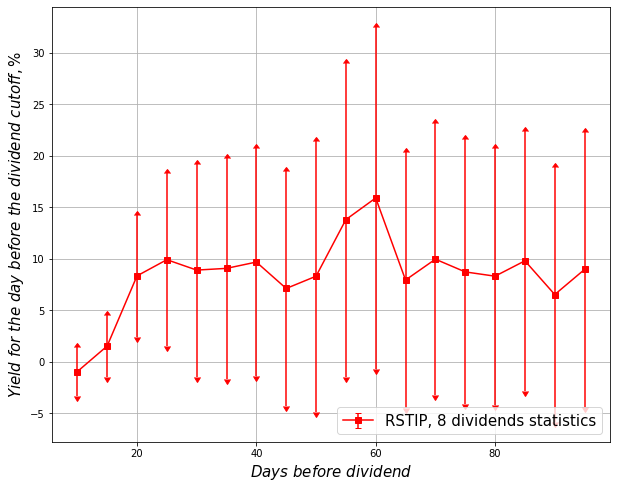

In [223]:
data = pd.read_csv("RSTIP.csv", header=0, sep=';')
div_data = pd.read_csv('rstip_div.csv', header=0, sep=';')

s = div_data['data']
div_data['data'] = pd.to_datetime(s, infer_datetime_format=True, dayfirst=True) 

s = data['<DATE>']
data['<DATE>'] = pd.to_datetime(s, infer_datetime_format=True, dayfirst=True) 

proc_days = []
for days in range(10, 100, 5):
    proc = []
    for x in div_data['data']:
        idx_div = data[data['<DATE>'] == x].index - 2
        idx_two_months = idx_div - days
        if not data.loc[idx_div, '<CLOSE>'].empty:
            proc.append((float(data.loc[idx_div, '<CLOSE>']) - float(data.loc[idx_two_months, '<CLOSE>'])) / float(data.loc[idx_two_months, '<CLOSE>']) * 100)
    proc = np.array(proc)
#     print(proc, days)
    proc_days.append({'mean, %': proc.mean(), 'diviation of mean, %': proc.std() / np.sqrt(len(proc)), 'days': days})
frame = pd.DataFrame(proc_days)


fig = plt.figure(figsize=(10,8))
legend = []
plt.xlabel('$Days \ before \ dividend$', fontsize=15)
plt.ylabel("$Yield \ for \ the \ day \ before \ the \ dividend \ cutoff, $" + '%', fontsize=15)
x = frame['days']
y = frame['mean, %']
err = frame['diviation of mean, %']
plt.errorbar(x, y, err, marker='s', color = 'r', mfc='red', uplims=True, lolims=True)
legend.append(f'RSTIP, {len(proc)} dividends statistics')
plt.legend(legend, loc="lower right", fontsize=15)
plt.grid()
plt.savefig('RSTIP')

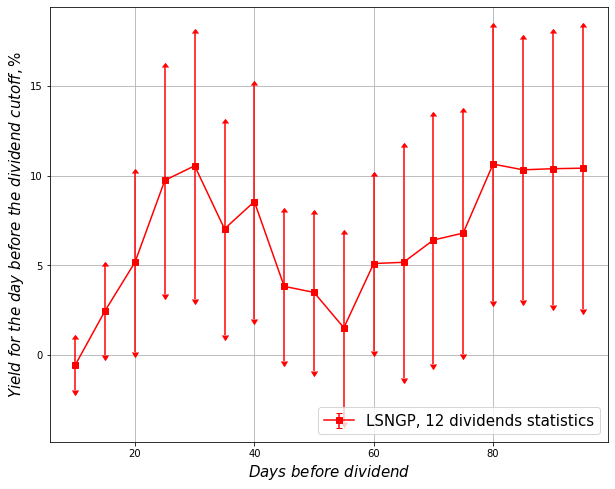

In [224]:
data = pd.read_csv("LSNGP.csv", header=0, sep=';')
div_data = pd.read_csv('lenrg_div.csv', header=0, sep=';')

s = div_data['data']
div_data['data'] = pd.to_datetime(s, infer_datetime_format=True, dayfirst=True) 

s = data['<DATE>']
data['<DATE>'] = pd.to_datetime(s, infer_datetime_format=True, dayfirst=True) 

proc_days = []
for days in range(10, 100, 5):
    proc = []
    for x in div_data['data']:
        idx_div = data[data['<DATE>'] == x].index - 2
        idx_two_months = idx_div - days
        if not data.loc[idx_div, '<CLOSE>'].empty:
            proc.append((float(data.loc[idx_div, '<CLOSE>']) - float(data.loc[idx_two_months, '<CLOSE>'])) / float(data.loc[idx_two_months, '<CLOSE>']) * 100)
    proc = np.array(proc)
    proc_days.append({'mean, %': proc.mean(), 'diviation of mean, %': proc.std() / np.sqrt(len(proc)), 'days': days})
frame = pd.DataFrame(proc_days)


fig = plt.figure(figsize=(10,8))
legend = []
plt.xlabel('$Days \ before \ dividend$', fontsize=15)
plt.ylabel("$Yield \ for \ the \ day \ before \ the \ dividend \ cutoff, $" + '%', fontsize=15)
x = frame['days']
y = frame['mean, %']
err = frame['diviation of mean, %']
plt.errorbar(x, y, err, marker='s', color = 'r', mfc='red', uplims=True, lolims=True)
legend.append(f'LSNGP, {len(proc)} dividends statistics')
plt.legend(legend, loc="lower right", fontsize=15)
plt.grid()
plt.savefig('LSNGP')

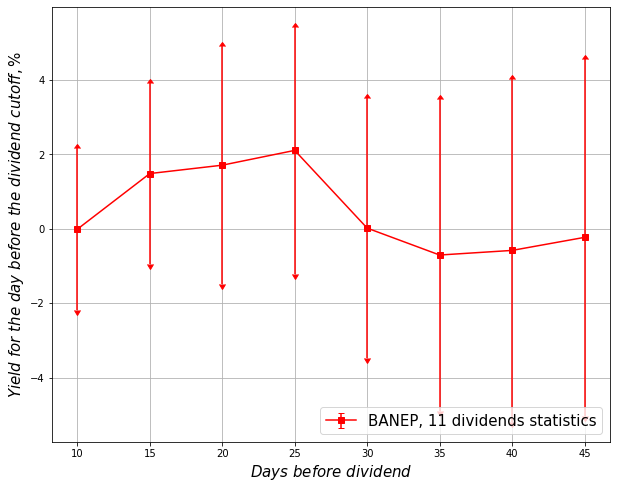

In [225]:
data = pd.read_csv("BANEP.csv", header=0, sep=';')
div_data = pd.read_csv('bash_div.csv', header=0, sep=';')

s = div_data['data']
div_data['data'] = pd.to_datetime(s, infer_datetime_format=True, dayfirst=True) 

s = data['<DATE>']
data['<DATE>'] = pd.to_datetime(s, infer_datetime_format=True, dayfirst=True) 

proc_days = []
for days in range(10, 50, 5):
    proc = []
    for x in div_data['data']:
        idx_div = data[data['<DATE>'] == x].index - 2
        idx_two_months = idx_div - days
        if not data.loc[idx_div, '<CLOSE>'].empty:
            proc.append((float(data.loc[idx_div, '<CLOSE>']) - float(data.loc[idx_two_months, '<CLOSE>'])) / float(data.loc[idx_two_months, '<CLOSE>']) * 100)
    proc = np.array(proc)
    proc_days.append({'mean, %': proc.mean(), 'diviation of mean, %': proc.std() / np.sqrt(len(proc)), 'days': days})
frame = pd.DataFrame(proc_days)


fig = plt.figure(figsize=(10,8))
legend = []
plt.xlabel('$Days \ before \ dividend$', fontsize=15)
plt.ylabel("$Yield \ for \ the \ day \ before \ the \ dividend \ cutoff, $" + '%', fontsize=15)
x = frame['days']
y = frame['mean, %']
err = frame['diviation of mean, %']
plt.errorbar(x, y, err, marker='s', color = 'r', mfc='red', uplims=True, lolims=True)
legend.append(f'BANEP, {len(proc)} dividends statistics')
plt.legend(legend, loc="lower right", fontsize=15)
plt.grid()
plt.savefig('BANEP')

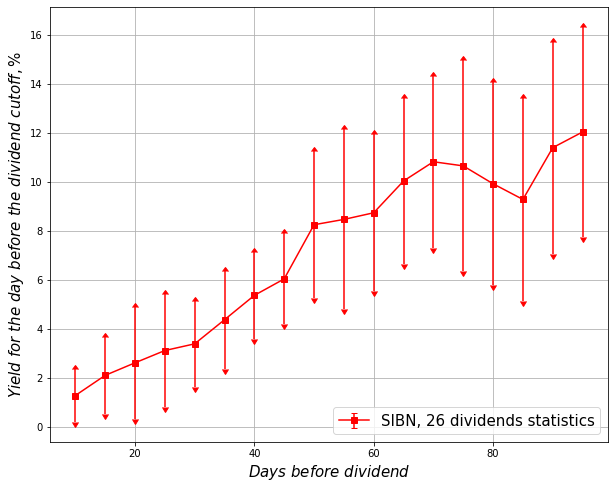

In [227]:
data = pd.read_csv("SIBN.csv", header=0, sep=';')
div_data = pd.read_csv('sibn_div.csv', header=0, sep=';')

s = div_data['data']
div_data['data'] = pd.to_datetime(s, infer_datetime_format=True, dayfirst=True) 

s = data['<DATE>']
data['<DATE>'] = pd.to_datetime(s, infer_datetime_format=True, dayfirst=True) 

proc_days = []

for days in range(10, 100, 5):
    proc = []
    dd = []
    for x in div_data['data']:
        idx_div = data[data['<DATE>'] == x].index - 2
        idx_two_months = idx_div - days
        if not data.loc[idx_div, '<CLOSE>'].empty:
            proc.append((float(data.loc[idx_div, '<CLOSE>']) - float(data.loc[idx_two_months, '<CLOSE>'])) / float(data.loc[idx_two_months, '<CLOSE>']) * 100)
            dd.append(100 * float(div_data[div_data['data'] == x]['div']) / float(data.loc[idx_div, '<CLOSE>']))

    proc = np.array(proc)
#     dd = np.array(dd)
#     proc_days.append((proc.mean(), proc, dd, days))
    proc_days.append({'mean, %': proc.mean(), 'diviation of mean, %': proc.std() / np.sqrt(len(proc)), 'days': days})
frame = pd.DataFrame(proc_days)


fig = plt.figure(figsize=(10,8))
legend = []
plt.xlabel('$Days \ before \ dividend$', fontsize=15)
plt.ylabel("$Yield \ for \ the \ day \ before \ the \ dividend \ cutoff, $" + '%', fontsize=15)
x = frame['days']
y = frame['mean, %']
err = frame['diviation of mean, %']
plt.errorbar(x, y, err, marker='s', color = 'r', mfc='red', uplims=True, lolims=True)
legend.append(f'SIBN, {len(proc)} dividends statistics')
plt.legend(legend, loc="lower right", fontsize=15)
plt.grid()
plt.savefig('SIBN')

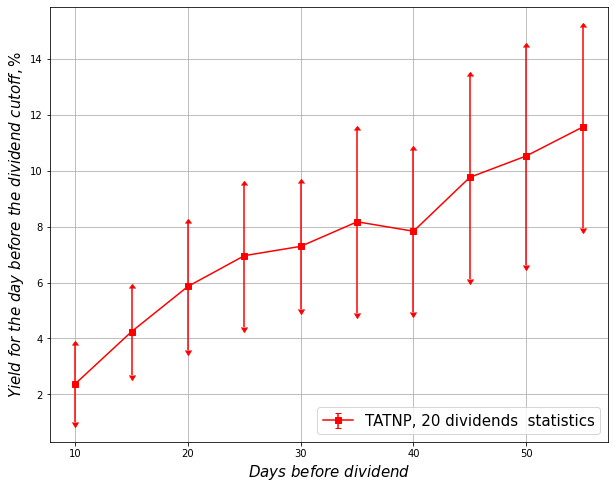

In [228]:
data = pd.read_csv("TATNP.csv", header=0, sep=';')
div_data = pd.read_csv('tat_div.csv', header=0, sep=';')

s = div_data['data']
div_data['data'] = pd.to_datetime(s, infer_datetime_format=True, dayfirst=True) 

s = data['<DATE>']
data['<DATE>'] = pd.to_datetime(s, infer_datetime_format=True, dayfirst=True) 

proc_days = []
for days in range(10, 60, 5):
    proc = []
    for x in div_data['data']:
        idx_div = data[data['<DATE>'] == x].index - 2
        idx_two_months = idx_div - days
        if not data.loc[idx_div, '<CLOSE>'].empty:
            proc.append((float(data.loc[idx_div, '<CLOSE>']) - float(data.loc[idx_two_months, '<CLOSE>'])) / float(data.loc[idx_two_months, '<CLOSE>']) * 100)
    proc = np.array(proc)
    proc_days.append({'mean, %': proc.mean(), 'diviation of mean, %': proc.std() / np.sqrt(len(proc)), 'days': days})
frame = pd.DataFrame(proc_days)


fig = plt.figure(figsize=(10,8))
legend = []
plt.xlabel('$Days \ before \ dividend$', fontsize=15)
plt.ylabel("$Yield \ for \ the \ day \ before \ the \ dividend \ cutoff, $" + '%', fontsize=15)
x = frame['days']
y = frame['mean, %']
err = frame['diviation of mean, %']
plt.errorbar(x, y, err, marker='s', color = 'r', mfc='red', uplims=True, lolims=True)
legend.append(f'TATNP, {len(proc)} dividends  statistics')
plt.legend(legend, loc="lower right", fontsize=15)
plt.grid()
plt.savefig('TATNP')

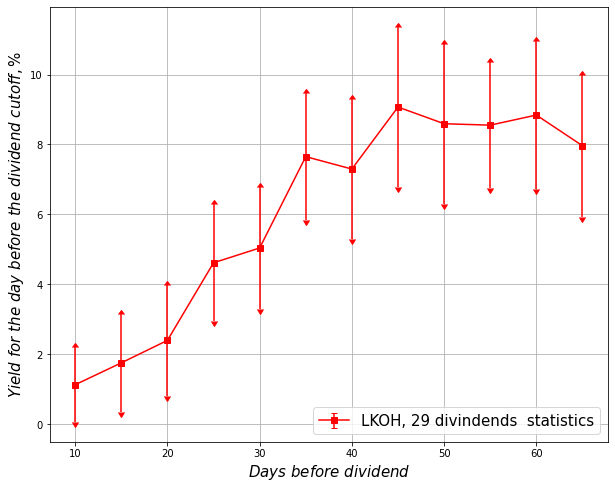

In [510]:
data = pd.read_csv("LKOH.csv", header=0, sep=';')
div_data = pd.read_csv('lcoh_div.csv', header=0, sep=';')

s = div_data['data']
div_data['data'] = pd.to_datetime(s, infer_datetime_format=True, dayfirst=True) 

s = data['<DATE>']
data['<DATE>'] = pd.to_datetime(s, infer_datetime_format=True, dayfirst=True) 

proc_days = []
for days in range(10, 70, 5):
    proc = []
    for x in div_data['data']:
        idx_div = data[data['<DATE>'] == x].index - 2
        idx_two_months = idx_div - days
        if not data.loc[idx_div, '<CLOSE>'].empty:
            proc.append((float(data.loc[idx_div, '<CLOSE>']) - float(data.loc[idx_two_months, '<CLOSE>'])) / float(data.loc[idx_two_months, '<CLOSE>']) * 100)
    proc = np.array(proc)
    proc_days.append({'mean, %': proc.mean(), 'diviation of mean, %': proc.std() / np.sqrt(len(proc)), 'days': days})
frame = pd.DataFrame(proc_days)


fig = plt.figure(figsize=(10,8))
legend = []
plt.xlabel('$Days \ before \ dividend$', fontsize=15)
plt.ylabel("$Yield \ for \ the \ day \ before \ the \ dividend \ cutoff, $" + '%', fontsize=15)
x = frame['days']
y = frame['mean, %']
err = frame['diviation of mean, %']
plt.errorbar(x, y, err, marker='s', color = 'r', mfc='red', uplims=True, lolims=True)
legend.append(f'LKOH, {len(proc)} divindends  statistics')
plt.legend(legend, loc="lower right", fontsize=15)
plt.grid()
plt.savefig('LKOH')

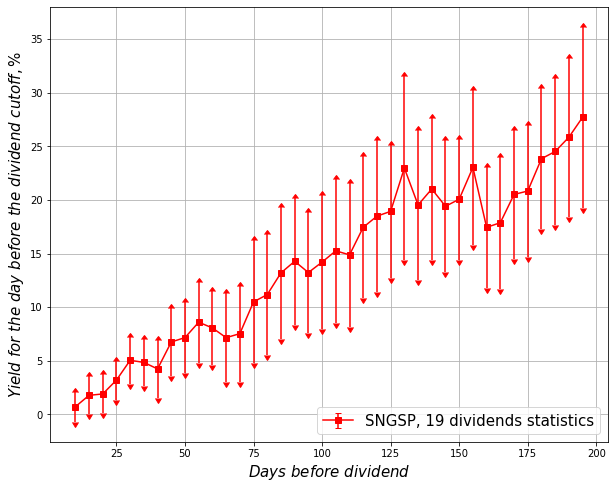

In [230]:
data = pd.read_csv("SNGSP.csv", header=0, sep=';')
div_data = pd.read_csv('songs_div.csv', header=0, sep=';')

s = div_data['data']
div_data['data'] = pd.to_datetime(s, infer_datetime_format=True, dayfirst=True) 

s = data['<DATE>']
data['<DATE>'] = pd.to_datetime(s, infer_datetime_format=True, dayfirst=True) 

proc_days = []
for days in range(10, 200, 5):
    proc = []
    for x in div_data['data']:
        idx_div = data[data['<DATE>'] == x].index - 2
        idx_two_months = idx_div - days
        if not data.loc[idx_div, '<CLOSE>'].empty:
            proc.append((float(data.loc[idx_div, '<CLOSE>']) - float(data.loc[idx_two_months, '<CLOSE>'])) / float(data.loc[idx_two_months, '<CLOSE>']) * 100)
    proc = np.array(proc)
    proc_days.append({'mean, %': proc.mean(), 'diviation of mean, %': proc.std() / np.sqrt(len(proc)), 'days': days})
frame = pd.DataFrame(proc_days)


fig = plt.figure(figsize=(10,8))
legend = []
plt.xlabel('$Days \ before \ dividend$', fontsize=15)
plt.ylabel("$Yield \ for \ the \ day \ before \ the \ dividend \ cutoff, $" + '%', fontsize=15)
x = frame['days']
y = frame['mean, %']
err = frame['diviation of mean, %']
plt.errorbar(x, y, err, marker='s', color = 'r', mfc='red', uplims=True, lolims=True)
legend.append(f'SNGSP, {len(proc)} dividends statistics')
plt.legend(legend, loc="lower right", fontsize=15)
plt.grid()
plt.savefig('SNGSP')

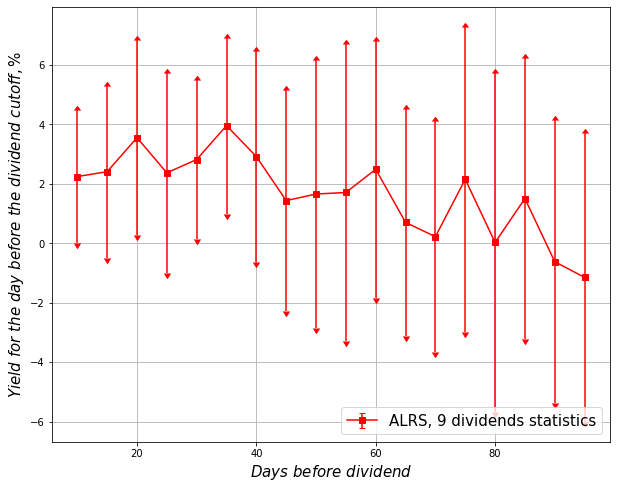

In [511]:
data = pd.read_csv("ALRS.csv", header=0, sep=';')
div_data = pd.read_csv('alrosa_div.csv', header=0, sep=';')

s = div_data['data']
div_data['data'] = pd.to_datetime(s, infer_datetime_format=True, dayfirst=True) 

s = data['<DATE>']
data['<DATE>'] = pd.to_datetime(s, infer_datetime_format=True, dayfirst=True) 

proc_days = []
for days in range(10, 100, 5):
    proc = []
    for x in div_data['data']:
        idx_div = data[data['<DATE>'] == x].index - 2
        idx_two_months = idx_div - days
        if not data.loc[idx_div, '<CLOSE>'].empty:
            proc.append((float(data.loc[idx_div, '<CLOSE>']) - float(data.loc[idx_two_months, '<CLOSE>'])) / float(data.loc[idx_two_months, '<CLOSE>']) * 100)
    proc = np.array(proc)
    proc_days.append({'mean, %': proc.mean(), 'diviation of mean, %': proc.std() / np.sqrt(len(proc)), 'days': days})
frame = pd.DataFrame(proc_days)


fig = plt.figure(figsize=(10,8))
legend = []
plt.xlabel('$Days \ before \ dividend$', fontsize=15)
plt.ylabel("$Yield \ for \ the \ day \ before \ the \ dividend \ cutoff, $" + '%', fontsize=15)
x = frame['days']
y = frame['mean, %']
err = frame['diviation of mean, %']
plt.errorbar(x, y, err, marker='s', color = 'r', mfc='red', uplims=True, lolims=True)
legend.append(f'ALRS, {len(proc)} dividends statistics')
plt.legend(legend, loc="lower right", fontsize=15)
plt.grid()
plt.savefig('ALRS')

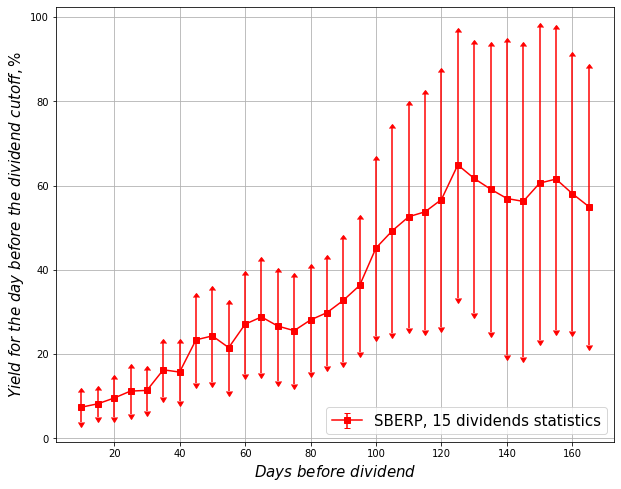

In [232]:
data = pd.read_csv("SBERP.csv", header=0, sep=';')
div_data = pd.read_csv('sberp_div.csv', header=0, sep=';')

s = div_data['data']
div_data['data'] = pd.to_datetime(s, infer_datetime_format=True, dayfirst=True) 

s = data['<DATE>']
data['<DATE>'] = pd.to_datetime(s, infer_datetime_format=True, dayfirst=True) 

proc_days = []
for days in range(10, 170, 5):
    proc = []
    for x in div_data['data']:
        idx_div = data[data['<DATE>'] == x].index - 2
        idx_two_months = idx_div - days
        if not data.loc[idx_div, '<CLOSE>'].empty:
            proc.append((float(data.loc[idx_div, '<CLOSE>']) - float(data.loc[idx_two_months, '<CLOSE>'])) / float(data.loc[idx_two_months, '<CLOSE>']) * 100)
    proc = np.array(proc)
    proc_days.append({'mean, %': proc.mean(), 'diviation of mean, %': proc.std() / np.sqrt(len(proc)), 'days': days})
frame = pd.DataFrame(proc_days)


fig = plt.figure(figsize=(10,8))
legend = []
plt.xlabel('$Days \ before \ dividend$', fontsize=15)
plt.ylabel("$Yield \ for \ the \ day \ before \ the \ dividend \ cutoff, $" + '%', fontsize=15)
x = frame['days']
y = frame['mean, %']
err = frame['diviation of mean, %']
plt.errorbar(x, y, err, marker='s', color = 'r', mfc='red', uplims=True, lolims=True)
legend.append(f'SBERP, {len(proc)} dividends statistics')
plt.legend(legend, loc="lower right", fontsize=15)
plt.grid()
plt.savefig('SBERP')

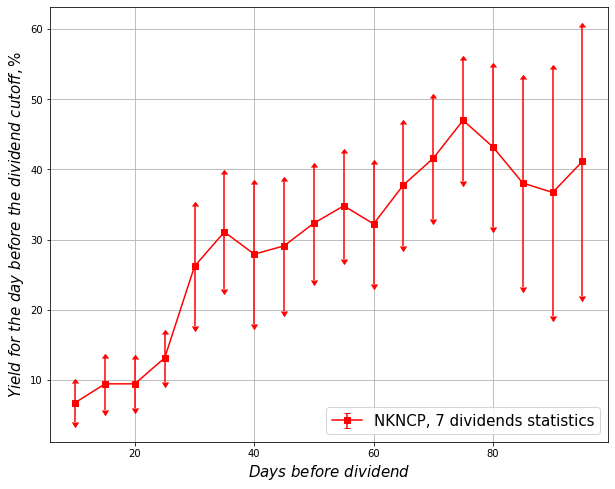

In [233]:
data = pd.read_csv("NKNCP.csv", header=0, sep=';')
div_data = pd.read_csv('nknch_div.csv', header=0, sep=';')

s = div_data['data']
div_data['data'] = pd.to_datetime(s, infer_datetime_format=True, dayfirst=True) 

s = data['<DATE>']
data['<DATE>'] = pd.to_datetime(s, infer_datetime_format=True, dayfirst=True) 

proc_days = []
for days in range(10, 100, 5):
    proc = []
    for x in div_data['data']:
        idx_div = data[data['<DATE>'] == x].index - 2
        idx_two_months = idx_div - days
        if not data.loc[idx_div, '<CLOSE>'].empty:
            proc.append((float(data.loc[idx_div, '<CLOSE>']) - float(data.loc[idx_two_months, '<CLOSE>'])) / float(data.loc[idx_two_months, '<CLOSE>']) * 100)
    proc = np.array(proc)
    proc_days.append({'mean, %': proc.mean(), 'diviation of mean, %': proc.std() / np.sqrt(len(proc)), 'days': days})
frame = pd.DataFrame(proc_days)


fig = plt.figure(figsize=(10,8))
legend = []
plt.xlabel('$Days \ before \ dividend$', fontsize=15)
plt.ylabel("$Yield \ for \ the \ day \ before \ the \ dividend \ cutoff, $" + '%', fontsize=15)
x = frame['days']
y = frame['mean, %']
err = frame['diviation of mean, %']
plt.errorbar(x, y, err, marker='s', color = 'r', mfc='red', uplims=True, lolims=True)
legend.append(f'NKNCP, {len(proc)} dividends statistics')
plt.legend(legend, loc="lower right", fontsize=15)
plt.grid()
plt.savefig('NKNCP')

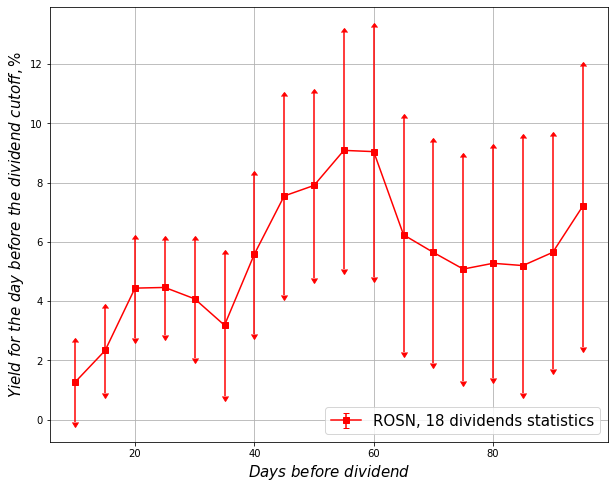

In [234]:
data = pd.read_csv("ROSN.csv", header=0, sep=';')
div_data = pd.read_csv('rosn_div.csv', header=0, sep=';')

s = div_data['data']
div_data['data'] = pd.to_datetime(s, infer_datetime_format=True, dayfirst=True) 

s = data['<DATE>']
data['<DATE>'] = pd.to_datetime(s, infer_datetime_format=True, dayfirst=True) 

proc_days = []
for days in range(10, 100, 5):
    proc = []
    for x in div_data['data']:
        idx_div = data[data['<DATE>'] == x].index - 2
        idx_two_months = idx_div - days
        if not data.loc[idx_div, '<CLOSE>'].empty:
            proc.append((float(data.loc[idx_div, '<CLOSE>']) - float(data.loc[idx_two_months, '<CLOSE>'])) / float(data.loc[idx_two_months, '<CLOSE>']) * 100)
    proc = np.array(proc)
    proc_days.append({'mean, %': proc.mean(), 'diviation of mean, %': proc.std() / np.sqrt(len(proc)), 'days': days})
frame = pd.DataFrame(proc_days)


fig = plt.figure(figsize=(10,8))
legend = []
plt.xlabel('$Days \ before \ dividend$', fontsize=15)
plt.ylabel("$Yield \ for \ the \ day \ before \ the \ dividend \ cutoff, $" + '%', fontsize=15)
x = frame['days']
y = frame['mean, %']
err = frame['diviation of mean, %']
plt.errorbar(x, y, err, marker='s', color = 'r', mfc='red', uplims=True, lolims=True)
legend.append(f'ROSN, {len(proc)} dividends statistics')
plt.legend(legend, loc="lower right", fontsize=15)
plt.grid()
plt.savefig('ROSN')

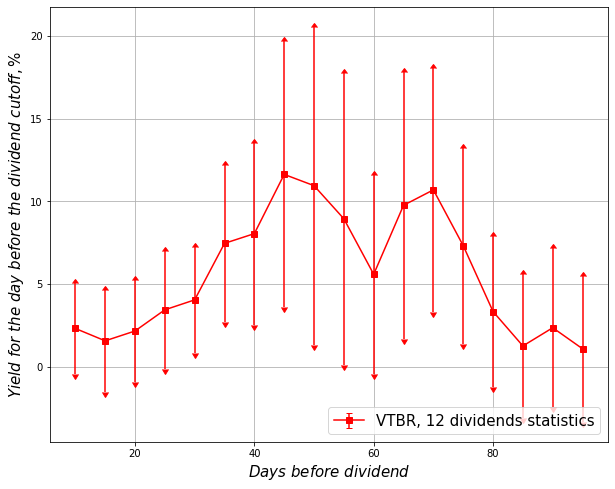

In [235]:
data = pd.read_csv("VTBR.csv", header=0, sep=';')
div_data = pd.read_csv('vtb_div.csv', header=0, sep=';')

s = div_data['data']
div_data['data'] = pd.to_datetime(s, infer_datetime_format=True, dayfirst=True) 

s = data['<DATE>']
data['<DATE>'] = pd.to_datetime(s, infer_datetime_format=True, dayfirst=True) 

proc_days = []
for days in range(10, 100, 5):
    proc = []
    for x in div_data['data']:
        idx_div = data[data['<DATE>'] == x].index - 2
        idx_two_months = idx_div - days
        if not data.loc[idx_div, '<CLOSE>'].empty:
            proc.append((float(data.loc[idx_div, '<CLOSE>']) - float(data.loc[idx_two_months, '<CLOSE>'])) / float(data.loc[idx_two_months, '<CLOSE>']) * 100)
    proc = np.array(proc)
    proc_days.append({'mean, %': proc.mean(), 'diviation of mean, %': proc.std() / np.sqrt(len(proc)), 'days': days})
frame = pd.DataFrame(proc_days)


fig = plt.figure(figsize=(10,8))
legend = []
plt.xlabel('$Days \ before \ dividend$', fontsize=15)
plt.ylabel("$Yield \ for \ the \ day \ before \ the \ dividend \ cutoff, $" + '%', fontsize=15)
x = frame['days']
y = frame['mean, %']
err = frame['diviation of mean, %']
plt.errorbar(x, y, err, marker='s', color = 'r', mfc='red', uplims=True, lolims=True)
legend.append(f'VTBR, {len(proc)} dividends statistics')
plt.legend(legend, loc="lower right", fontsize=15)
plt.grid()
plt.savefig('VTBR')